In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from art.unsloth.model import get_model_and_tokenizer

model, tokenizer = get_model_and_tokenizer(
    model_name="unsloth/Qwen2.5-14B-Instruct",
    lora_rank=32,
)

model

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.15: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.109 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-14b-instruct-unsloth-bnb-4bit with actual GPU utilization = 59.54%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.11 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 8192. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 36.26 GB. Also swap space = 6 GB.
Unsloth: vLLM Bitsandbytes config using

[W318 18:39:19.454389831 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:38<00:00,  1.11it/s]
Unsloth 2025.3.15 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(152064, 5120, padding_idx=151654)
        (layers): ModuleList(
          (0-4): 5 x Qwen2DecoderLayer(
            (self_attn): Qwen2Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linea

Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 6


In [44]:
task = asyncio.create_task(train())

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 3 | Total steps = 250
O^O/ \_/ \    Batch size per device = 6 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (6 x 1 x 1) = 6
 "-____-"     Trainable parameters = 137,625,600/14,000,000,000 (0.98% trained)


Waiting for inputs


In [45]:
task.cancel()

True

In [22]:
GRPOTrainer.compute_loss.__code__

<code object compute_loss at 0xed7b720, file "/home/gcpuser/sky_workdir/examples/unsloth_compiled_cache/UnslothGRPOTrainer.py", line 1104>

In [18]:
import inspect

print(inspect.getsource(GRPOTrainer.__module__))

TypeError: module, class, method, function, traceback, frame, or code object was expected, got str

In [11]:
trainer.create_model_card

<bound method _UnslothGRPOTrainer.create_model_card of <UnslothGRPOTrainer.UnslothGRPOTrainer object at 0x727dec06a840>>

In [3]:
import art
import asyncio
from dotenv import load_dotenv
import json
import openai
import random
import re
from typing import TypedDict

load_dotenv()


class TemporalCluePuzzle(TypedDict):
    num_clues: int
    prompt: str
    solution: dict[str, str]


puzzles: list[TemporalCluePuzzle] = json.load(open("./data/temporal-clue/puzzles.json"))
val_puzzles = puzzles[:64]
test_puzzles = puzzles[64:128]
train_puzzles = puzzles[128:]
random.seed(42)
random.shuffle(train_puzzles)


api = art.UnslothAPI(wandb_project="agent-reinforcement-training")
model = await api.get_or_create_model(
    name="temporal-clue-unsloth-001",
    base_model="unsloth/Qwen2.5-14B-Instruct",
)


async def rollout(
    client: openai.AsyncOpenAI, puzzle: TemporalCluePuzzle
) -> art.Trajectory:
    messages: art.Messages = [{"role": "user", "content": puzzle["prompt"]}]
    chat_completion = await client.chat.completions.create(
        messages=messages, model=model.name
    )
    choice = chat_completion.choices[0]
    content = choice.message.content
    assert isinstance(content, str)
    num_correct = 0
    for key, value in puzzle["solution"].items():
        if matches := re.findall(rf"{key}\. ([A-Za-z \.:-]+)", content):
            match = matches[-1]
            if match.strip().lower() == value.lower():
                num_correct += 1
    reward = acc = num_correct / len(puzzle["solution"])
    return art.Trajectory(
        messages_and_choices=[*messages, choice], reward=reward, metrics={"acc": acc}
    )


stride = 1
for i in range(await model.get_iteration(), 1_000):
    async with model.openai_client(
        estimated_completion_tokens=900, verbosity=2
    ) as openai_client:
        val_groups, train_groups = await asyncio.gather(
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(2))
                    for puzzle in val_puzzles[:32]
                ),
                pbar_desc="val",
                stream_chat_completions=8,
            ),
            art.gather_groups(
                (
                    (rollout(openai_client, puzzle) for _ in range(50))
                    for puzzle in train_puzzles[i * stride : (i + 1) * stride]
                ),
                pbar_desc="train",
            ),
        )
        break
    await model.save(val_groups)
    await model.clear_iterations()
    await model.tune(
        train_groups, config=art.TuneConfig(plot_tensors=True, verbosity=2)
    )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.15: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.19 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-14b-instruct-unsloth-bnb-4bit with actual GPU utilization = 59.6%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.19 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 8192. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 36.35 GB. Also swap space = 6 GB.
Unsloth: vLLM Bitsandbytes config using kwargs

[W319 03:33:09.753232662 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Capturing CUDA graph shapes: 100%|██████████| 43/43 [00:42<00:00,  1.02it/s]
Unsloth 2025.3.15 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/50 [00:00<?, ?it/s]

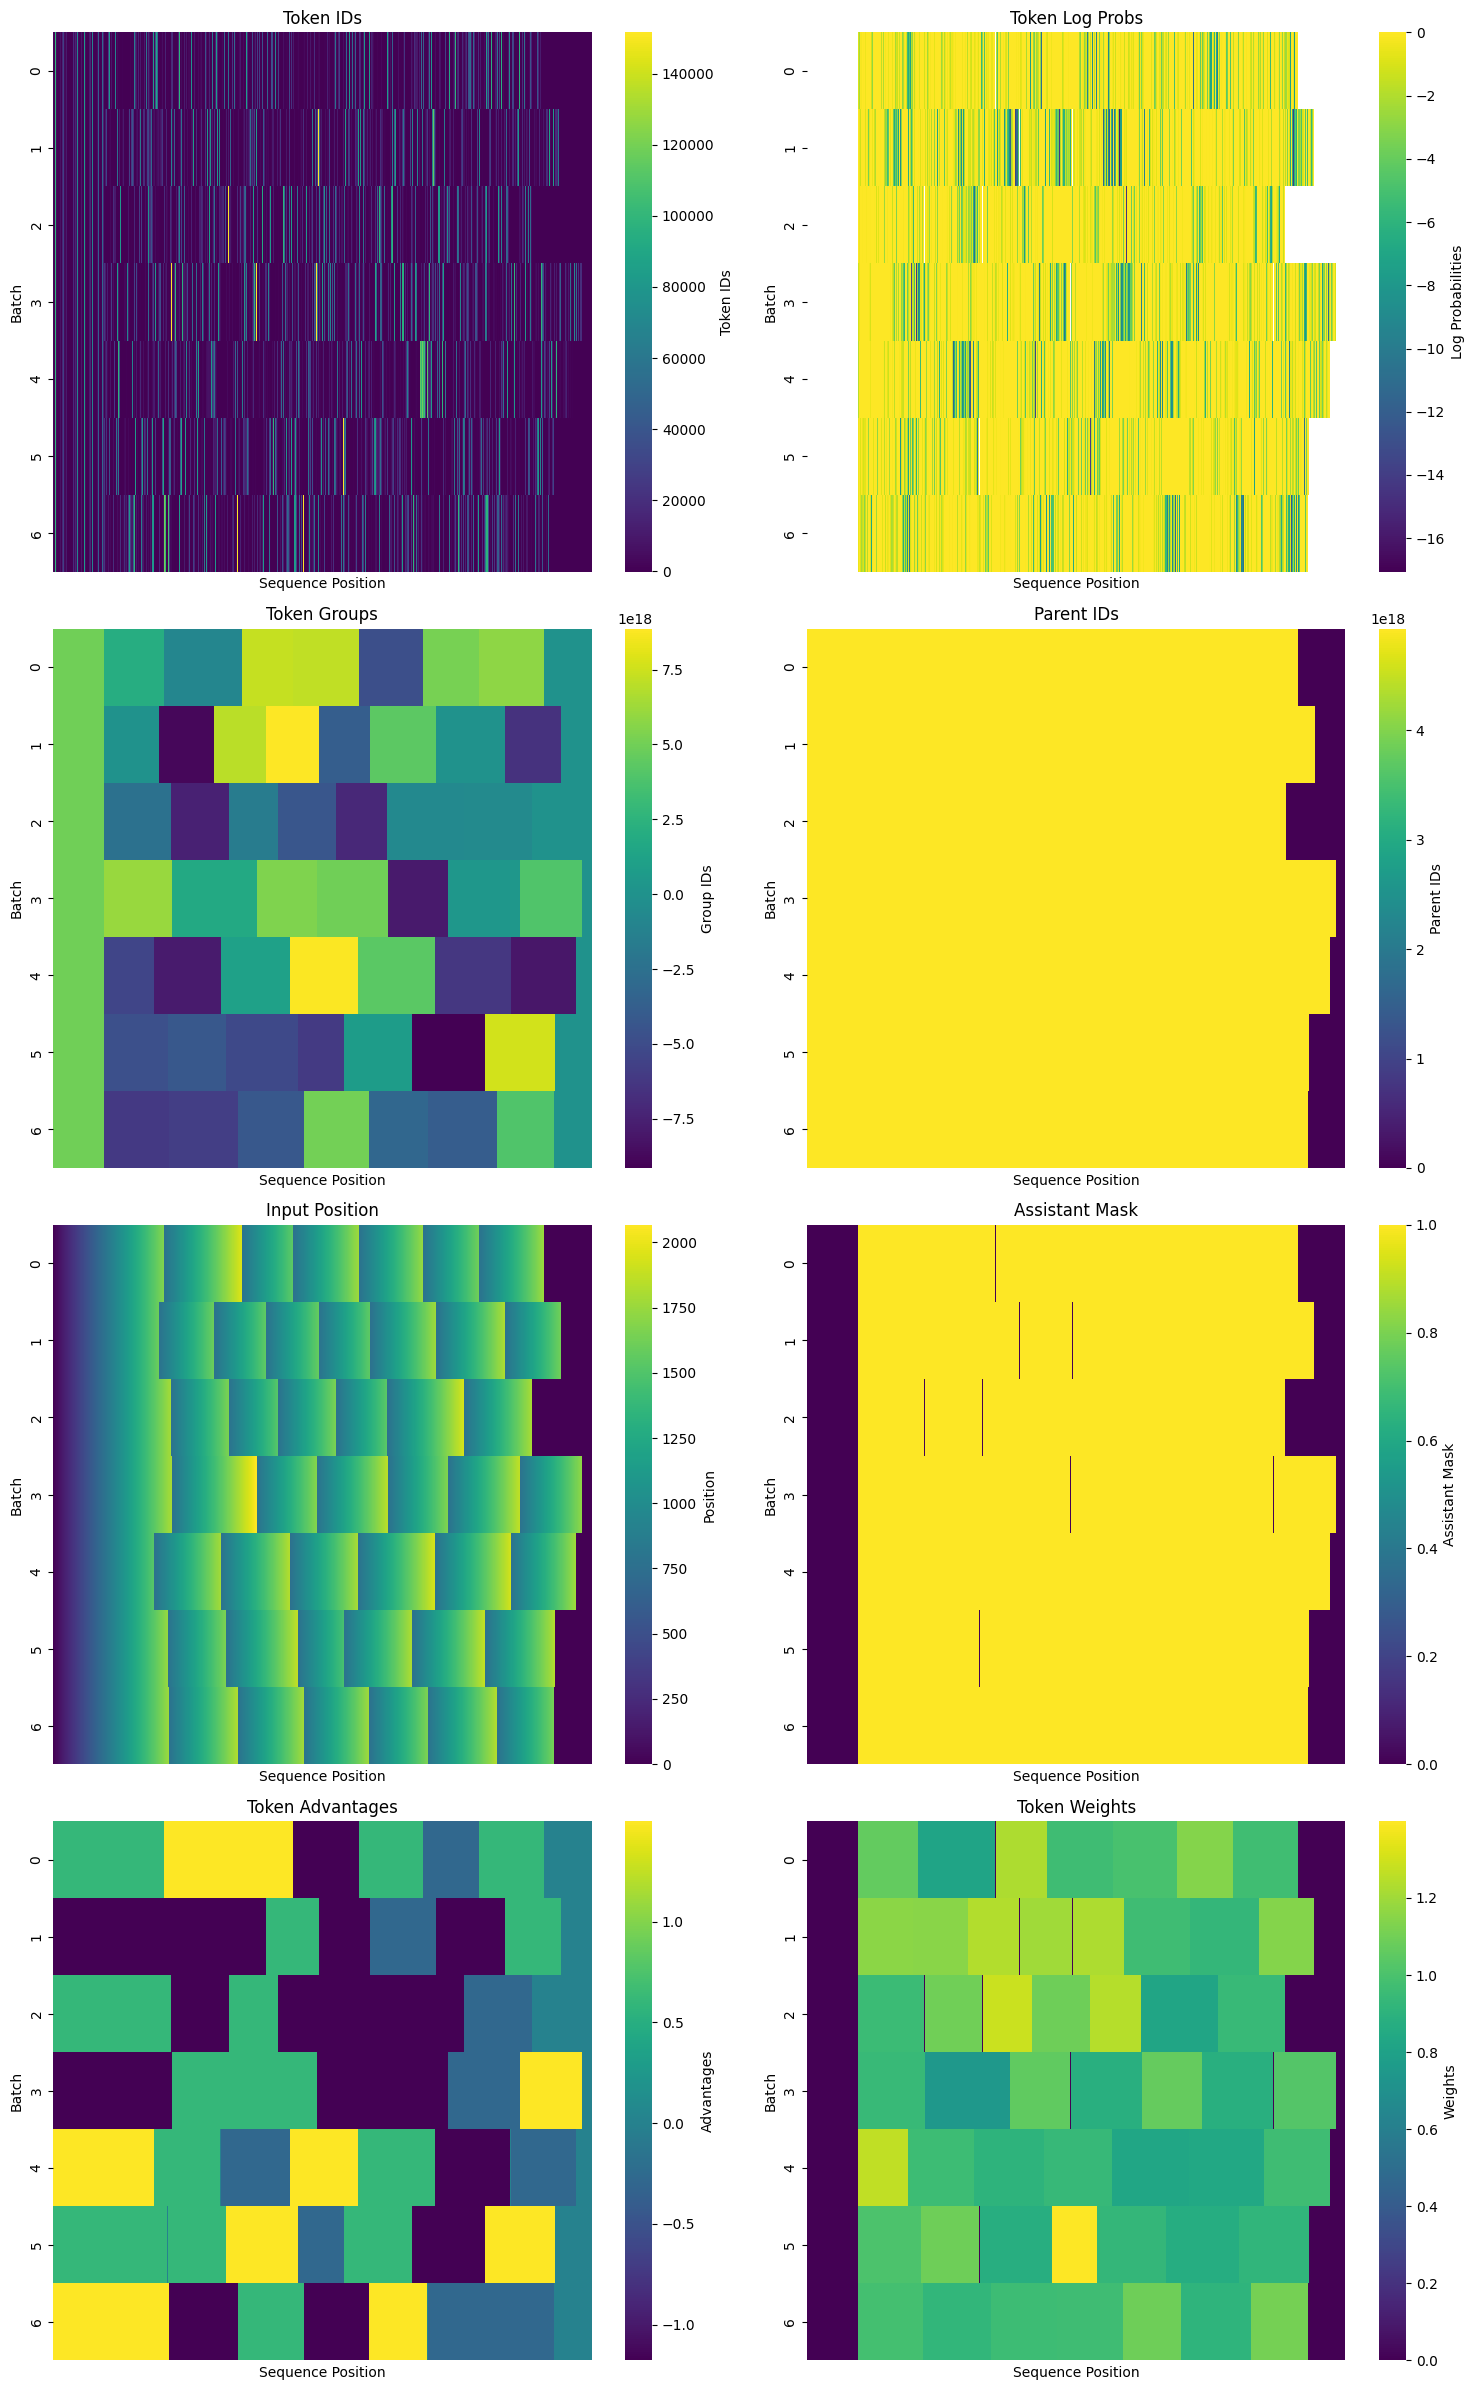

In [5]:
from art.unsloth.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from art.unsloth.tokenize import tokenize_trajectory_groups

tokenizer = model.api._model_and_tokenizer[1]
tokenized_results = list(
    tokenize_trajectory_groups(
        tokenizer,
        [
            [
                trajectory
                for trajectory in group
                if not isinstance(trajectory, BaseException)
            ]
            for group in train_groups
        ],
    )
)
packed_tensors = packed_tensors_from_tokenized_results(
    tokenized_results, 8192
)
plot_packed_tensors(packed_tensors)

In [6]:
import asyncio
from datasets import Dataset
import nest_asyncio
import torch
from art.unsloth.UnslothGRPOTrainer import UnslothGRPOConfig, UnslothGRPOTrainer
from typing import TypedDict

nest_asyncio.apply()

training_args = UnslothGRPOConfig(
    learning_rate=5e-6,
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="constant",
    optim="paged_adamw_8bit",
    beta=0.0,
    logging_steps=1,
    per_device_train_batch_size=5,
    gradient_accumulation_steps=1,  # Increase to 4 for smoother training
    num_generations=5,  # Decrease if out of memory
    max_prompt_length=2048,
    max_completion_length=8192 - 2048,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps=250,
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Can use Weights & Biases
    output_dir="outputs",
    use_vllm=False,
)


def infinite_generator():
    yield {"prompt": torch.tensor([[1]] * 50)}


def reward_func(*args, **kwargs):
    return 0


trainer = UnslothGRPOTrainer(
    model=api._model_and_tokenizer[0],  # type: ignore
    processing_class=api._model_and_tokenizer[1],  # type: ignore
    reward_funcs=reward_func,  # type: ignore
    args=training_args,
    train_dataset=Dataset.from_list([{"prompt": "hello, world!"} for _ in range(100)]),
)

In [7]:
class Inputs(TypedDict):
    prompt_ids: torch.Tensor
    prompt_mask: torch.Tensor
    completion_ids: torch.Tensor
    completion_mask: torch.Tensor
    advantages: torch.Tensor


input_queue: asyncio.Queue[Inputs] = asyncio.Queue()


def _async_prepare_inputs(*_, **__) -> dict[str, torch.Tensor]:
    async def get_inputs() -> Inputs:
        print("Waiting for inputs")
        return await input_queue.get()

    inputs = asyncio.run(get_inputs())

    # Concatenate prompt_ids with completion_ids
    prompt_completion_ids = torch.cat(
        [inputs["prompt_ids"], inputs["completion_ids"]], dim=1
    )

    # Concatenate prompt_mask with completion_mask for logit computation
    attention_mask = torch.cat(
        [inputs["prompt_mask"], inputs["completion_mask"]], dim=1
    )  # (B*G, P+C)

    logits_to_keep = inputs["completion_ids"].size(
        1
    )  # we only need to compute the logits for the completion tokens

    with torch.inference_mode():
        if trainer.ref_model is not None:
            ref_per_token_logps = trainer._get_per_token_logps(
                trainer.ref_model, prompt_completion_ids, attention_mask, logits_to_keep
            )
        else:
            with trainer.accelerator.unwrap_model(trainer.model).disable_adapter():
                ref_per_token_logps = trainer._get_per_token_logps(
                    trainer.model, prompt_completion_ids, attention_mask, logits_to_keep
                )

    return {
        "prompt_ids": inputs["prompt_ids"],
        "prompt_mask": inputs["prompt_mask"],
        "completion_ids": inputs["completion_ids"],
        "completion_mask": inputs["completion_mask"],
        "ref_per_token_logps": ref_per_token_logps,
        "advantages": inputs["advantages"],
    }


async def train() -> None:
    _prepare_inputs = trainer._prepare_inputs
    trainer._prepare_inputs = _async_prepare_inputs
    try:
        trainer.train()
    finally:
        trainer._prepare_inputs = _prepare_inputs